In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import matplotlib as mpl

from scipy import optimize

In [2]:
plt.rcParams["axes.linewidth"]  = 2.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]
# plt.rc("text", usetex=True)
plt.rc("font", size=22)


COLORS = ["f07167","219ebc","c767ac","E0A100","59a270"]
COLORS = ['#' + c if c[0] != '#' else c for c in COLORS ]

from cycler import cycler

# Update the default prop_cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=COLORS)

# Load tables

In [12]:
DIR = '/scratch/midway3/dhayaa/SHEARTESTS/DR3_Masked_SNR80/'

In [13]:
def combine(X):
    
    return np.concatenate([np.concatenate([X_i[:, 3], X_i[:, 4]]) for X_i in X])

def split_array(arr):
    
    splits = [arr[i:i+50] for i in range(0, len(arr), 50)]  # split the array into 50-point chunks
    
    return splits

def cov_to_corr(cov):
    
    return cov/np.outer(np.sqrt(np.diagonal(cov)), np.sqrt(np.diagonal(cov)))

In [16]:
def DO_FIT(DIR):
    
    cov = np.loadtxt(DIR + '/taustats_All_cov_treecorr.txt')
    cov = cov[50:, 50:] #Remove shear block

    tau_cov = cov[-150:, -150:]
    inv_tau_cov = np.linalg.inv(tau_cov)


    tau0_cov = cov[-150:-100,-150:-100]
    tau1_cov = cov[-100:-50, -100:-50]
    tau2_cov = cov[-50:,-50:]

    tau0_cov = np.diag(np.diag(tau0_cov))
    tau1_cov = np.diag(np.diag(tau1_cov))
    tau2_cov = np.diag(np.diag(tau2_cov))

    inv_tau0_cov = np.linalg.inv(tau0_cov) * (100 - 50)/(100 - 1) #Hartlap
    inv_tau1_cov = np.linalg.inv(tau1_cov) * (100 - 50)/(100 - 1)
    inv_tau2_cov = np.linalg.inv(tau2_cov) * (100 - 50)/(100 - 1)

    datavectors = [np.loadtxt(DIR +'/taustats_shear_2pt_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho0_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho1_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho2_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho3_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho4_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_rho5_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_tau0_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_tau1_treecorr.txt'),
                   np.loadtxt(DIR +'/taustats_tau2_treecorr.txt')]

    combined = combine(datavectors[:])

    mean = combined[50:]

    splits = split_array(mean)

    import emcee

    tau_data = np.concatenate(splits[-3:])

    # Define the log-likelihood function
    def log_likelihood(theta):

        alpha, beta, eta = theta

        rho0, rho1, rho2, rho3, rho4, rho5, tau0, tau1, tau2 = splits

        tau0_model = alpha*rho0 + beta*rho2 + eta*rho5
        tau1_model = alpha*rho2 + beta*rho1 + eta*rho4
        tau2_model = alpha*rho5 + beta*rho4 + eta*rho3

        diff0 = tau0 - tau0_model
        diff1 = tau1 - tau1_model
        diff2 = tau2 - tau2_model

        chi2 = (diff0 @ inv_tau0_cov @ diff0 + 
                diff1 @ inv_tau1_cov @ diff1 + 
                diff2 @ inv_tau2_cov @ diff2)

        return -chi2

    # Define the log-prior function
    def log_prior(theta):
        # Set uniform priors for a, b, c between -10 and 10
        if (-10 < theta[0] < 10) and (-10 < theta[1] < 10) and (-10 < theta[2] < 10):
            return 0.0
        else:
            return -np.inf

    # Define the log-posterior function
    def log_posterior(theta):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta)

    # Set up the emcee sampler
    ndim = 3
    nwalkers = 100
    pos = np.random.multivariate_normal([0.001, 1, -1], cov = np.diag([0.01, 0.5, 0.1])**2, size = nwalkers)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

    # Burn in the sampler
    pos, _, _ = sampler.run_mcmc(pos, 1000, progress = True)

    # Run the sampler for 1000 steps
    sampler.reset()
    sampler.run_mcmc(pos, 2000, progress = True)

    # Get the samples and flatten the chains
    samples = sampler.chain[:, :, :].reshape((-1, ndim))

    OUT[DIR] = samples

    # Print the median and 1-sigma uncertainties of a, b, c
    a_median, b_median, c_median = np.median(samples, axis=0)
    a_err = np.percentile(samples[:, 0], [16, 84]) - a_median
    b_err = np.percentile(samples[:, 1], [16, 84]) - b_median
    c_err = np.percentile(samples[:, 2], [16, 84]) - c_median

    print("----------------------------------")
    print("----------------------------------")
    print(DIR)
    print("a = {:.4f} +/- {:.4f}".format(a_median, np.mean(np.abs(a_err))))
    print("b = {:.4f} +/- {:.4f}".format(b_median, np.mean(np.abs(b_err))))
    print("c = {:.4f} +/- {:.4f}".format(c_median, np.mean(np.abs(c_err))))
    print("----------------------------------")

    # Find the index of the maximum log-probability
    max_log_prob_index = np.argmax(sampler.flatlnprobability)
    # Retrieve the corresponding sample
    best_fit_params = sampler.flatchain[max_log_prob_index]

    print("Best-fit parameters:", best_fit_params)

    chi2 = -log_likelihood(best_fit_params)
    print("CHI2:", chi2)
    
    return best_fit_params, samples


best_fit_params, samples = DO_FIT('/scratch/midway3/dhayaa/SHEARTESTS/DR3_Masked_SNR80/')

100%|██████████| 2000/2000 [00:09<00:00, 212.58it/s]

----------------------------------
----------------------------------
/scratch/midway3/dhayaa/SHEARTESTS/DR3_Masked_SNR80/
a = 0.0027 +/- 0.0022
b = 1.3821 +/- 0.0731
c = -3.6267 +/- 0.8841
----------------------------------
Best-fit parameters: [ 2.60423319e-03  1.38259081e+00 -3.65029403e+00]
CHI2: 153.77060398782277


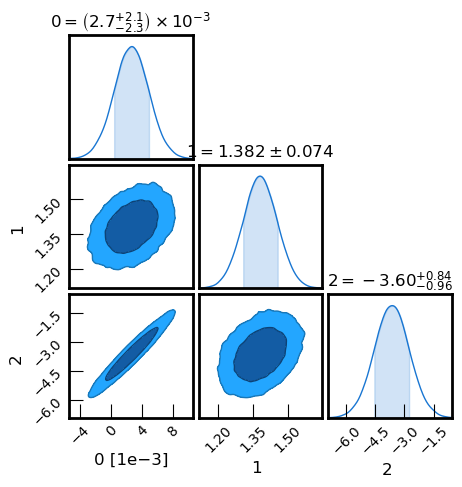

In [60]:
from chainconsumer import ChainConsumer

c = ChainConsumer()

c.add_chain(samples)

c.plotter.plot();

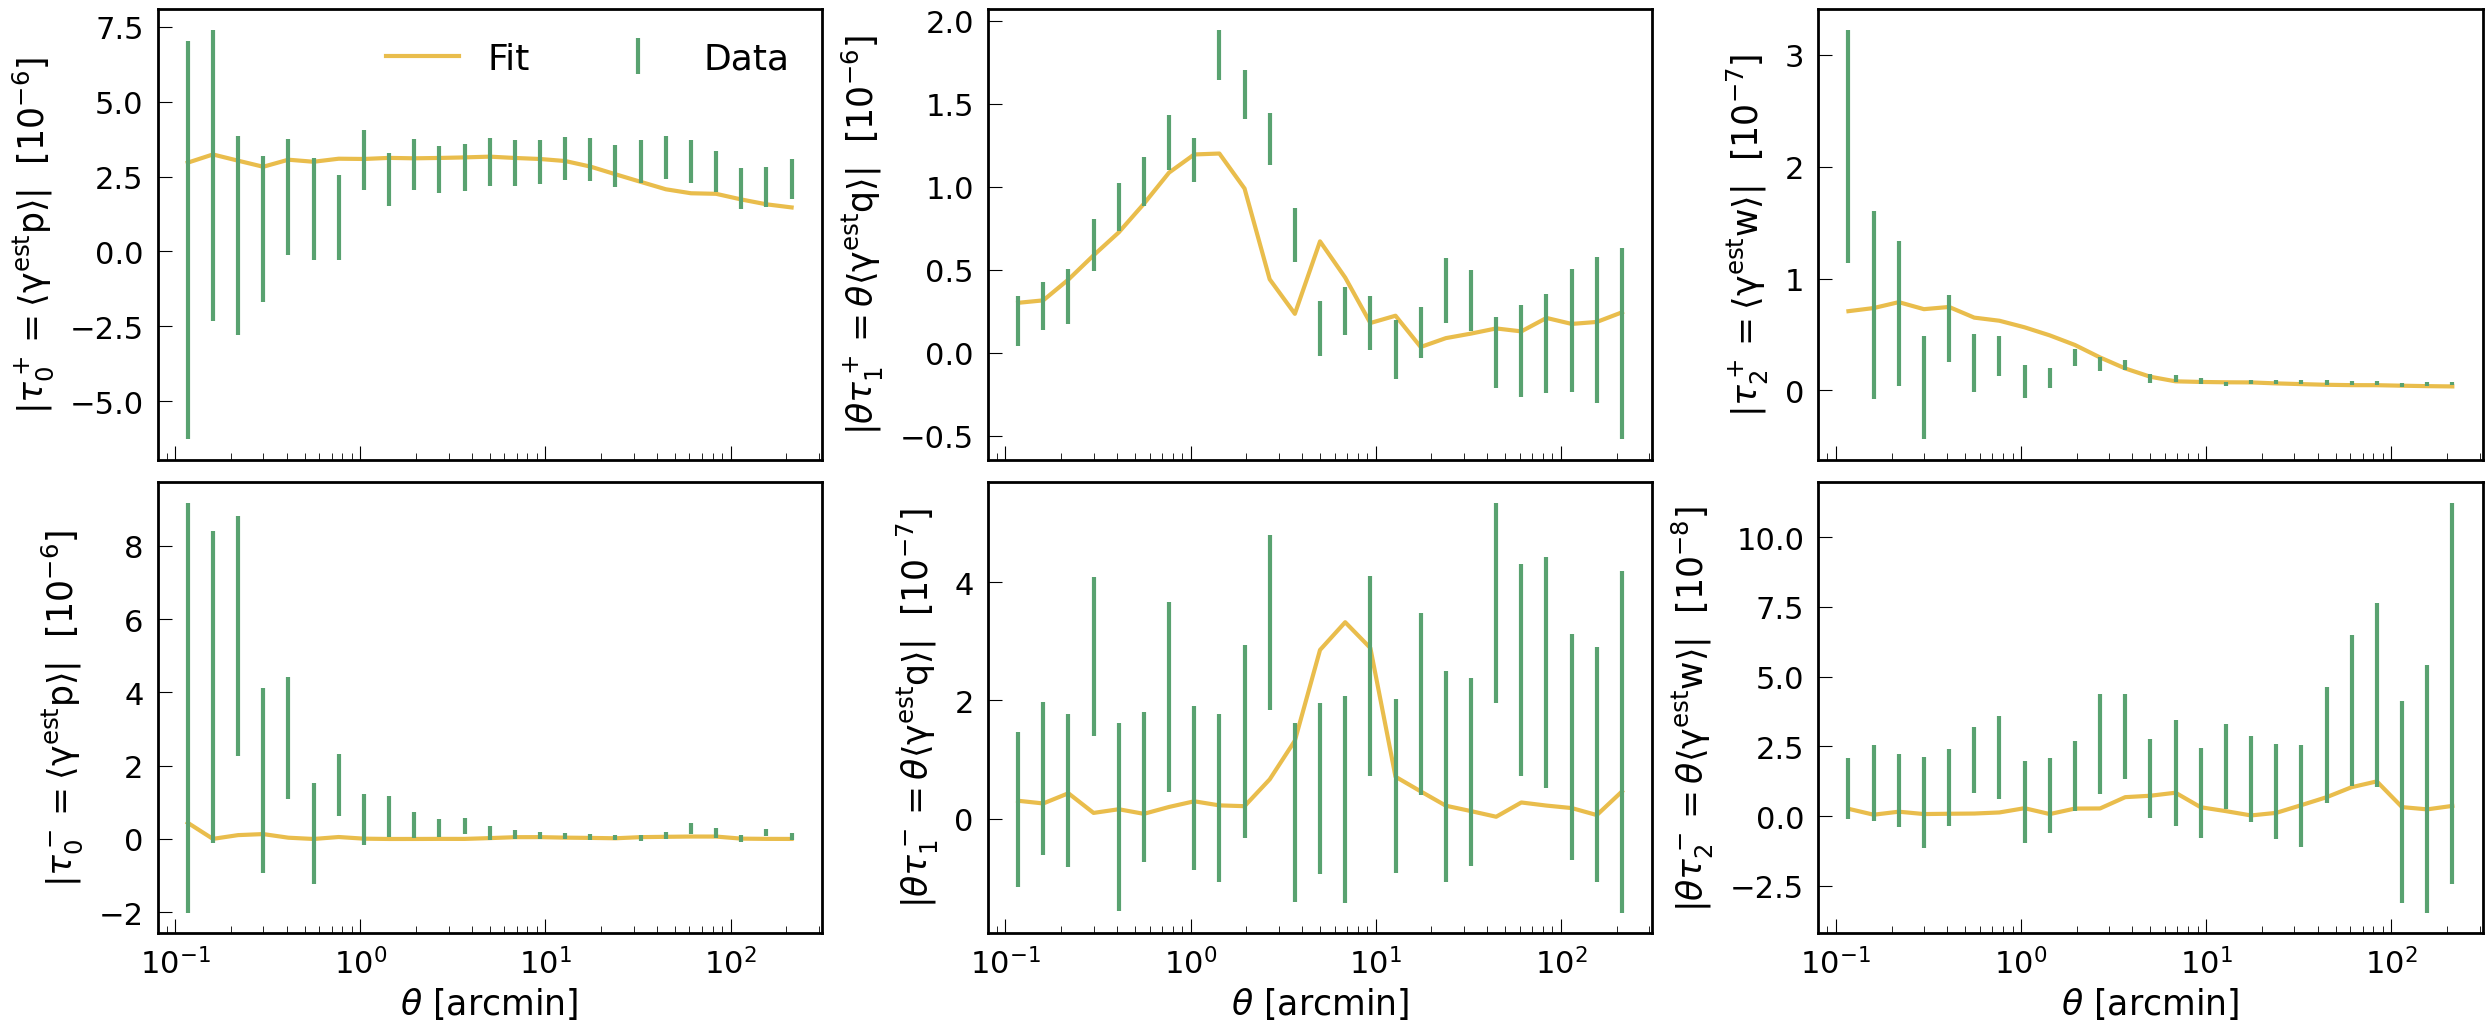

In [60]:
plt.rcParams["axes.linewidth"]  = 2.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc("font", size=22)

fig, ax = plt.subplots(2, 3, figsize = (30, 12), sharex = True)

plt.subplots_adjust(hspace = 0.05, wspace = 0.25)

[a.set_xscale('log') for a in ax.flatten()]
# [a.set_yscale('log') for a in ax.flatten()]

x = np.loadtxt(DIR + 'taustats_tau%d_treecorr.txt' % 0)

cc = [1e-6, 1e-6, 1e-6, 1e-7, 1e-7, 1e-8]
f = x[:, 0]
ax.flatten()[0].errorbar(x[:, 0], 1/cc[0]*np.abs(x[:, 3]), yerr = 1/cc[0]*x[:, 7], fmt = 'none', color = COLORS[4], lw = 3, label = 'Data')
ax.flatten()[0 + 3].errorbar(x[:, 0], 1/cc[1]*np.abs(x[:, 4]), yerr = 1/cc[1]*x[:, 8], fmt = 'none', color = COLORS[4], lw = 3)

x = np.loadtxt(DIR + 'taustats_tau%d_treecorr.txt' % 1)
ax.flatten()[1].errorbar(x[:, 0], 1/cc[2]*f*np.abs(x[:, 3]), yerr = 1/cc[2]*f*x[:, 7], fmt = 'none', color = COLORS[4], lw = 3, label = 'Data')
ax.flatten()[1 + 3].errorbar(x[:, 0], 1/cc[3]*f*np.abs(x[:, 4]), yerr = 1/cc[3]*f*x[:, 8], fmt = 'none', color = COLORS[4], lw = 3)

x = np.loadtxt(DIR + 'taustats_tau%d_treecorr.txt' % 2)
ax.flatten()[2].errorbar(x[:, 0], 1/cc[4]*np.abs(x[:, 3]), yerr = 1/cc[4]*x[:, 7], fmt = 'none', color = COLORS[4], lw = 3, label = 'Data')
ax.flatten()[2 + 3].errorbar(x[:, 0], 1/cc[5]*f*np.abs(x[:, 4]), yerr = 1/cc[5]*f*x[:, 8], fmt = 'none', color = COLORS[4], lw = 3)

    
ax.flatten()[0].plot(x[:, 0], 1/cc[0]*np.abs(datavectors[1][:, 3] * a_median + 
                                     datavectors[3][:, 3] * b_median + 
                                     datavectors[6][:, 3] * c_median), color = COLORS[3], lw = 3, alpha = 0.7, label = 'Fit', zorder = -1)

ax.flatten()[3].plot(x[:, 0], 1/cc[1]*np.abs(datavectors[1][:, 4] * a_median + 
                                     datavectors[3][:, 4] * b_median + 
                                     datavectors[6][:, 4] * c_median), color = COLORS[3], lw = 3, alpha = 0.7, zorder = -1)


ax.flatten()[1].plot(x[:, 0], 1/cc[2]*f*np.abs(datavectors[3][:, 3] * a_median + 
                                     datavectors[2][:, 3] * b_median + 
                                     datavectors[5][:, 3] * c_median), color = COLORS[3], lw = 3, alpha = 0.7, zorder = -1)

ax.flatten()[4].plot(x[:, 0], 1/cc[3]*f*np.abs(datavectors[3][:, 4] * a_median + 
                                     datavectors[2][:, 4] * b_median + 
                                     datavectors[5][:, 4] * c_median), color = COLORS[3], lw = 3, alpha = 0.7, zorder = -1)


ax.flatten()[2].plot(x[:, 0], 1/cc[4]*np.abs(datavectors[6][:, 3] * a_median + 
                                     datavectors[5][:, 3] * b_median + 
                                     datavectors[4][:, 3] * c_median), color = COLORS[3], lw = 3, alpha = 0.7, zorder = -1)

ax.flatten()[5].plot(x[:, 0], 1/cc[5]*f*np.abs(datavectors[6][:, 4] * a_median + 
                                     datavectors[5][:, 4] * b_median + 
                                     datavectors[4][:, 4] * c_median), color = COLORS[3], lw = 3, alpha = 0.7, zorder = -1)
    
for i, l in enumerate([r'|$\tau_0^+ = \langle \rm \gamma^{\rm est} p\rangle$|  [$10^{-6}$]',
                       r'|$\theta\tau_1^+ = \theta\langle \rm \gamma^{\rm est} q\rangle$|  [$10^{-6}$]',
                       r'|$\tau_2^+ = \langle \rm \gamma^{\rm est} w\rangle$|  [$10^{-7}$]',
                       r'|$\tau_0^- = \langle \rm \gamma^{\rm est} p\rangle$|  [$10^{-6}$]',
                       r'|$\theta\tau_1^- = \theta\langle \rm \gamma^{\rm est} q\rangle$|  [$10^{-7}$]',
                       r'|$\theta\tau_2^- = \theta\langle \rm \gamma^{\rm est} w\rangle$|  [$10^{-8}$]']):
    ax.flatten()[i].set_ylabel(r'%s' % l, size = 25, labelpad = 10)
    
ax.flat[0].legend(fontsize = 26, frameon = False, ncol = 2)
[ax.flatten()[i].set_xlabel(r'$\theta$ [arcmin]', size = 25) for i in [3, 4, 5]];

[a.tick_params(pad = 10) for a in ax.flat]
plt.savefig('./Tau_Stats.pdf', bbox_inches = 'tight', dpi = 400)

In [3]:
import pandas as pd

X = pd.read_csv('/project/chihway/dhayaa/DECADE/FieldCenters_DR3_1_20240305.csv'); print(len(X))
X = X.drop_duplicates(); print(len(X))


57699
57699


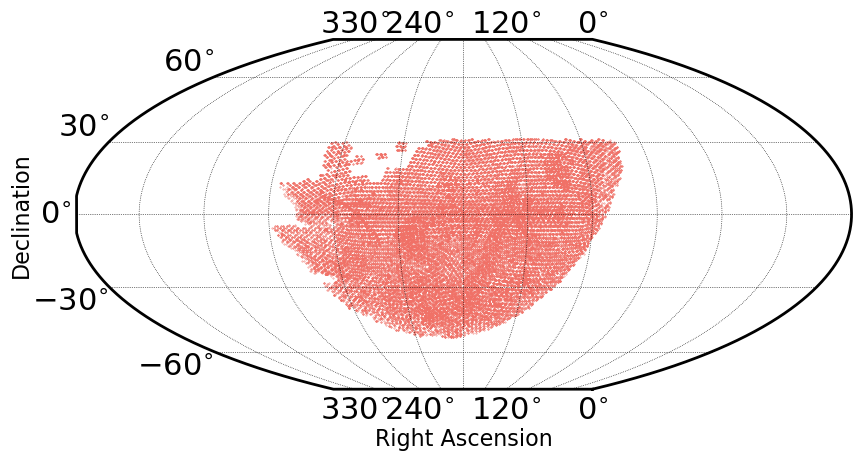

In [4]:
import skyproj


s = skyproj.McBrydeSkyproj(lon_0=180)

s.scatter(X['RADEG'].values, X['DECDEG'].values, s = 0.1)

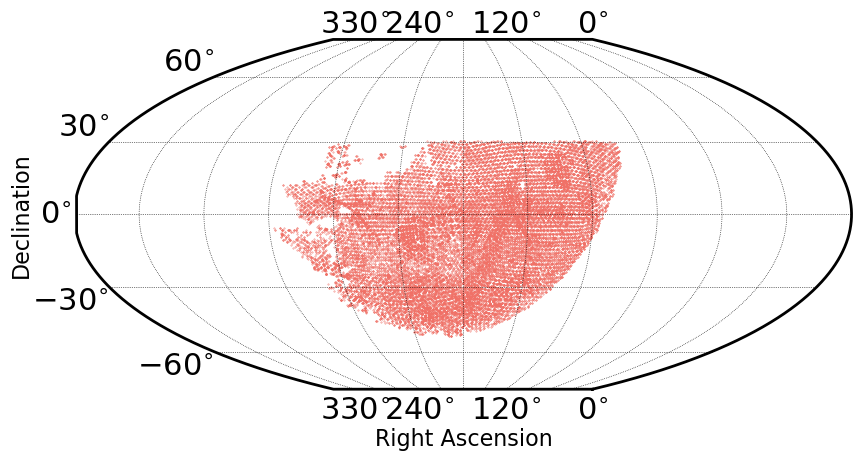

In [76]:
import skyproj


s = skyproj.McBrydeSkyproj(lon_0=180)

s.scatter(X['RADEG'].values, X['DECDEG'].values, s = 0.1)

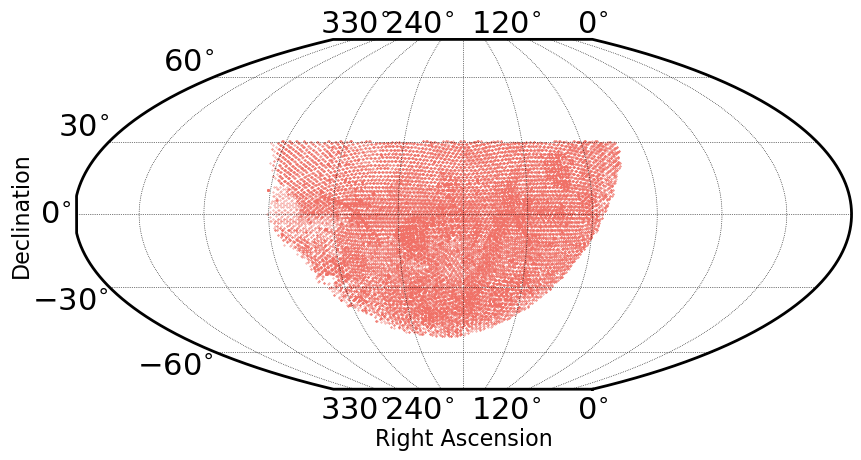

In [74]:
import skyproj


s = skyproj.McBrydeSkyproj(lon_0=180)

s.scatter(X['RADEG'].values, X['DECDEG'].values, s = 0.1)

In [ ]:
plt.hist()

100%|██████████| 2000/2000 [00:06<00:00, 311.67it/s]


----------------------------------
----------------------------------
/scratch/midway3/dhayaa/SHEARTESTS/DR3_Masked_SNR80/
a = 0.0026 +/- 0.0022
b = 1.3836 +/- 0.0719
c = -3.6424 +/- 0.8995
----------------------------------
Best-fit parameters: [ 2.66763522e-03  1.38273137e+00 -3.62556204e+00]
CHI2: 153.77049486703189


100%|██████████| 2000/2000 [00:05<00:00, 354.33it/s]


----------------------------------
----------------------------------
/scratch/midway3/dhayaa/SHEARTESTS/DR3_Masked_SNR60/
a = 0.0041 +/- 0.0025
b = 1.3815 +/- 0.0662
c = -2.8799 +/- 0.9210
----------------------------------
Best-fit parameters: [ 0.00399955  1.38054829 -2.89877447]
CHI2: 123.78849910750462


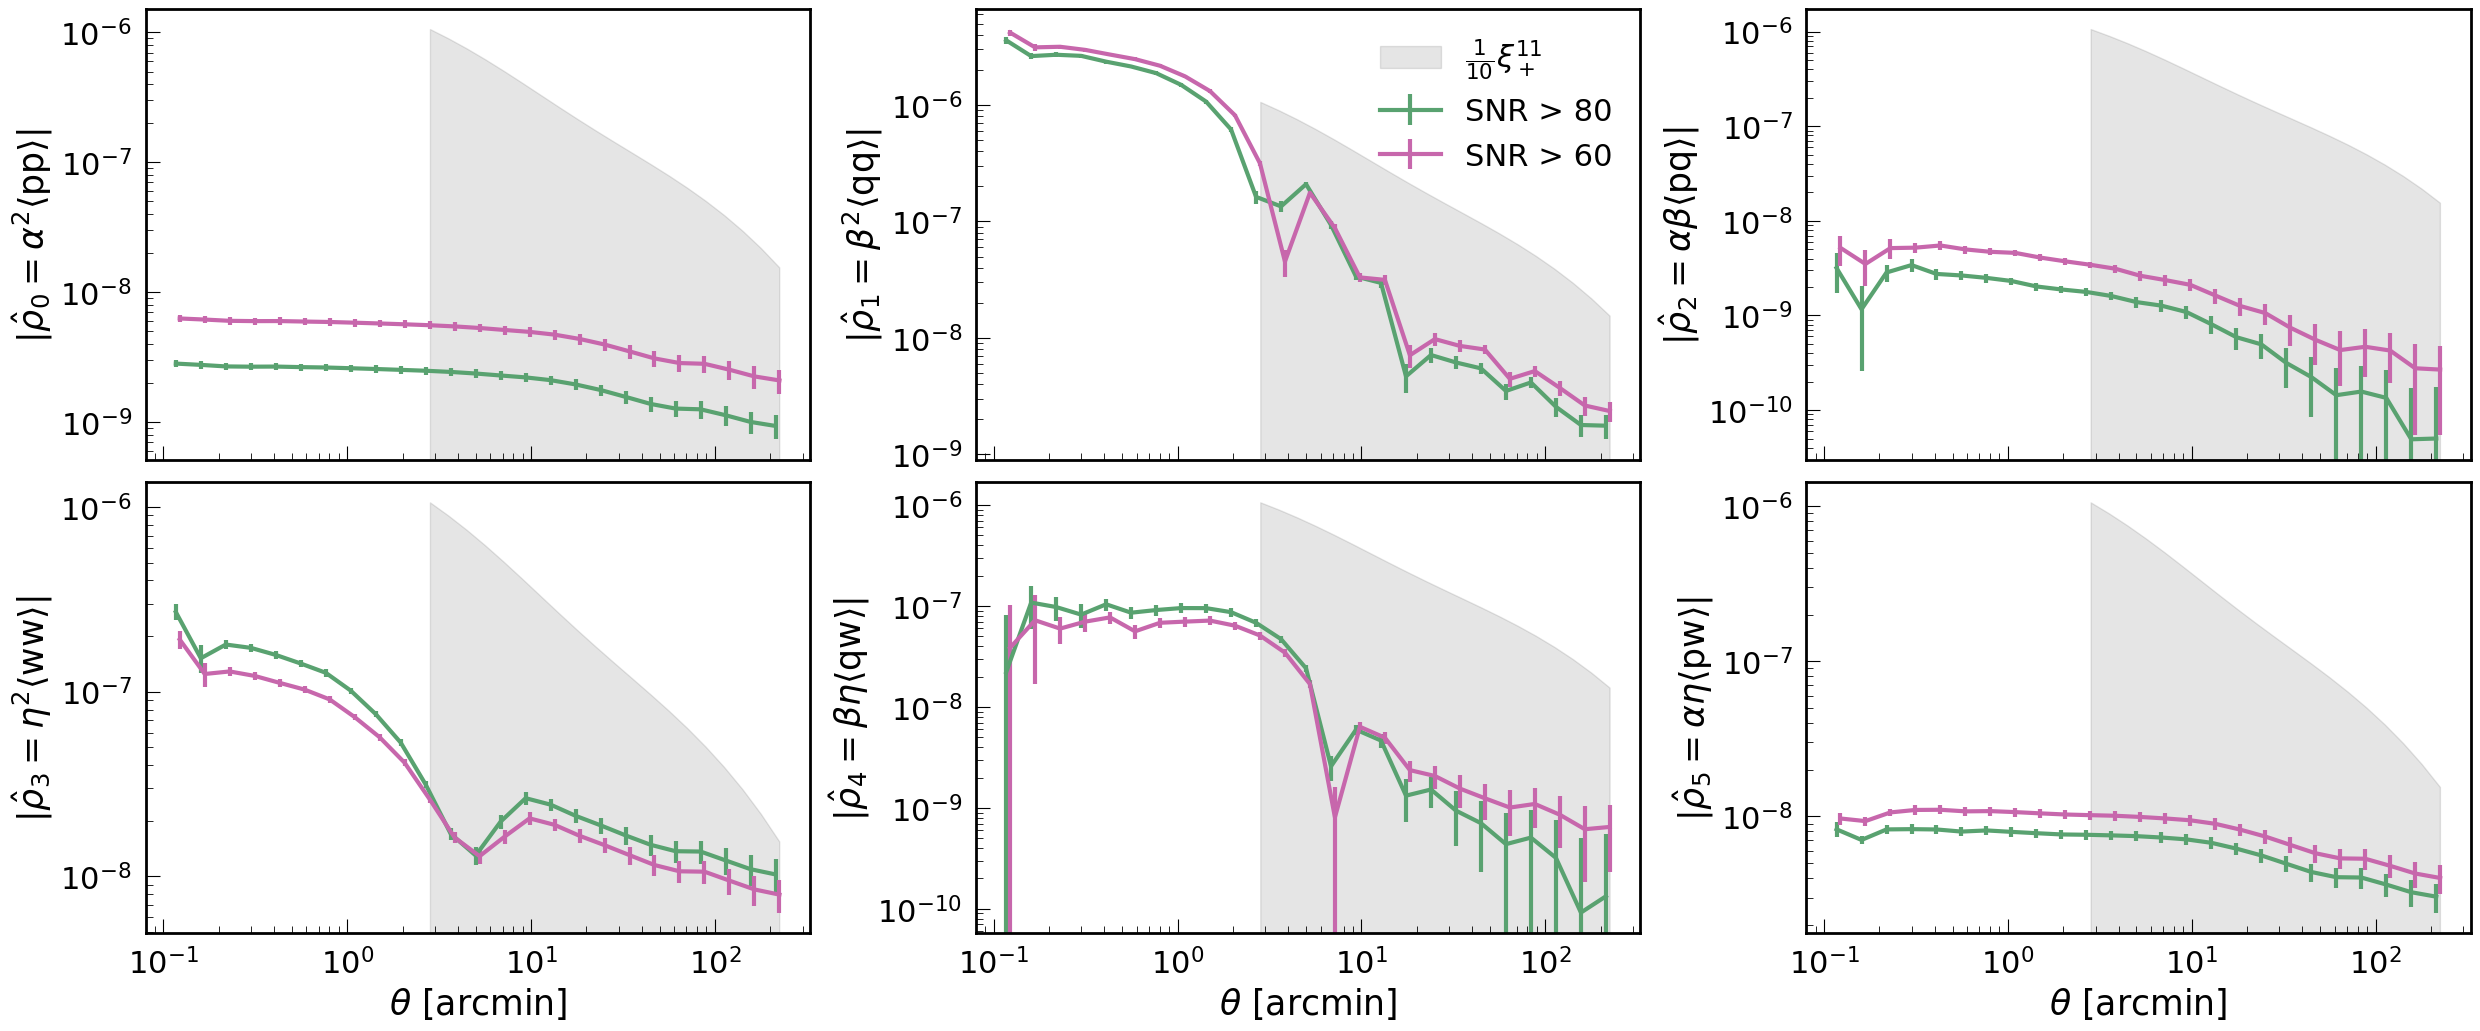

In [30]:
from astropy.io import fits

plt.rc("font", size=22)

fig, ax = plt.subplots(2, 3, figsize = (30, 12), sharex = True)

plt.subplots_adjust(hspace = 0.05, wspace = 0.25)

[a.loglog() for a in ax.flatten()]
    

xi_plus_11 = fits.open('/project/chihway/dhayaa/DECADE/cosmosis/Lucas_files/simulated_shear_Oct17th.fits')[2].data[:20]
for i in range(6):
    ax.flatten()[i].fill_between(xi_plus_11['ANG'], np.zeros(20), 0.1*xi_plus_11['VALUE'], color = 'k', alpha = 0.1, label = r'$\frac{1}{10}\xi_+^{11}$')

    
best_fit_params, samples = DO_FIT('/scratch/midway3/dhayaa/SHEARTESTS/DR3_Masked_SNR80/')

a, b, e = best_fit_params
coeffs = [a*a, b*b, a*b, e*e, b*e, a*e]

for i in range(6):

    x = np.loadtxt('/scratch/midway3/dhayaa/SHEARTESTS/DR3_Masked_SNR80/' + '/taustats_rho%d_treecorr.txt' % i)
    ax.flatten()[i].errorbar(x[:, 0], np.abs(coeffs[i]) * np.abs(x[:, 3]), yerr = np.abs(coeffs[i]) * x[:, 7], 
                             lw = 3, color = COLORS[4], label = 'SNR > 80')
    
    
    
best_fit_params, samples = DO_FIT('/scratch/midway3/dhayaa/SHEARTESTS/DR3_Masked_SNR60/')

a, b, e = best_fit_params
coeffs = [a*a, b*b, a*b, e*e, b*e, a*e]

for i in range(6):

    x = np.loadtxt('/scratch/midway3/dhayaa/SHEARTESTS/DR3_Masked_SNR60/' + '/taustats_rho%d_treecorr.txt' % i)
    ax.flatten()[i].errorbar(x[:, 0] * (1 + 0.05), np.abs(coeffs[i]) * np.abs(x[:, 3]), yerr = np.abs(coeffs[i]) * x[:, 7], 
                             lw = 3, color = COLORS[2], alpha = 1, label = 'SNR > 60')
        

ax.flat[1].legend(fontsize = 22, frameon = False)

for i, l in enumerate([r'$\hat{\rho}_0 = \alpha^2\langle {\rm pp} \rangle$',
                       r'$\hat{\rho}_1 = \beta^2\langle {\rm qq} \rangle$',
                       r'$\hat{\rho}_2 = \alpha\beta\langle {\rm pq} \rangle$',
                       r'$\hat{\rho}_3 = \eta^2\langle {\rm ww} \rangle$',
                       r'$\hat{\rho}_4 = \beta\eta\langle {\rm qw} \rangle$',
                       r'$\hat{\rho}_5 = \alpha\eta\langle {\rm pw} \rangle$']):
    ax.flatten()[i].set_ylabel(r'|%s|' % l, size = 25)
    
[ax.flatten()[i].set_xlabel(r'$\theta$ [arcmin]', size = 25) for i in [3, 4, 5]];

[ax.flatten()[i].set_xlabel(r'$\theta$ [arcmin]', size = 25) for i in [3, 4, 5]];

[a.tick_params(pad = 10) for a in ax.flat]

plt.savefig('./Rowe_stats.pdf', bbox_inches = 'tight', dpi = 400)

# Check rho stats/Tau stats

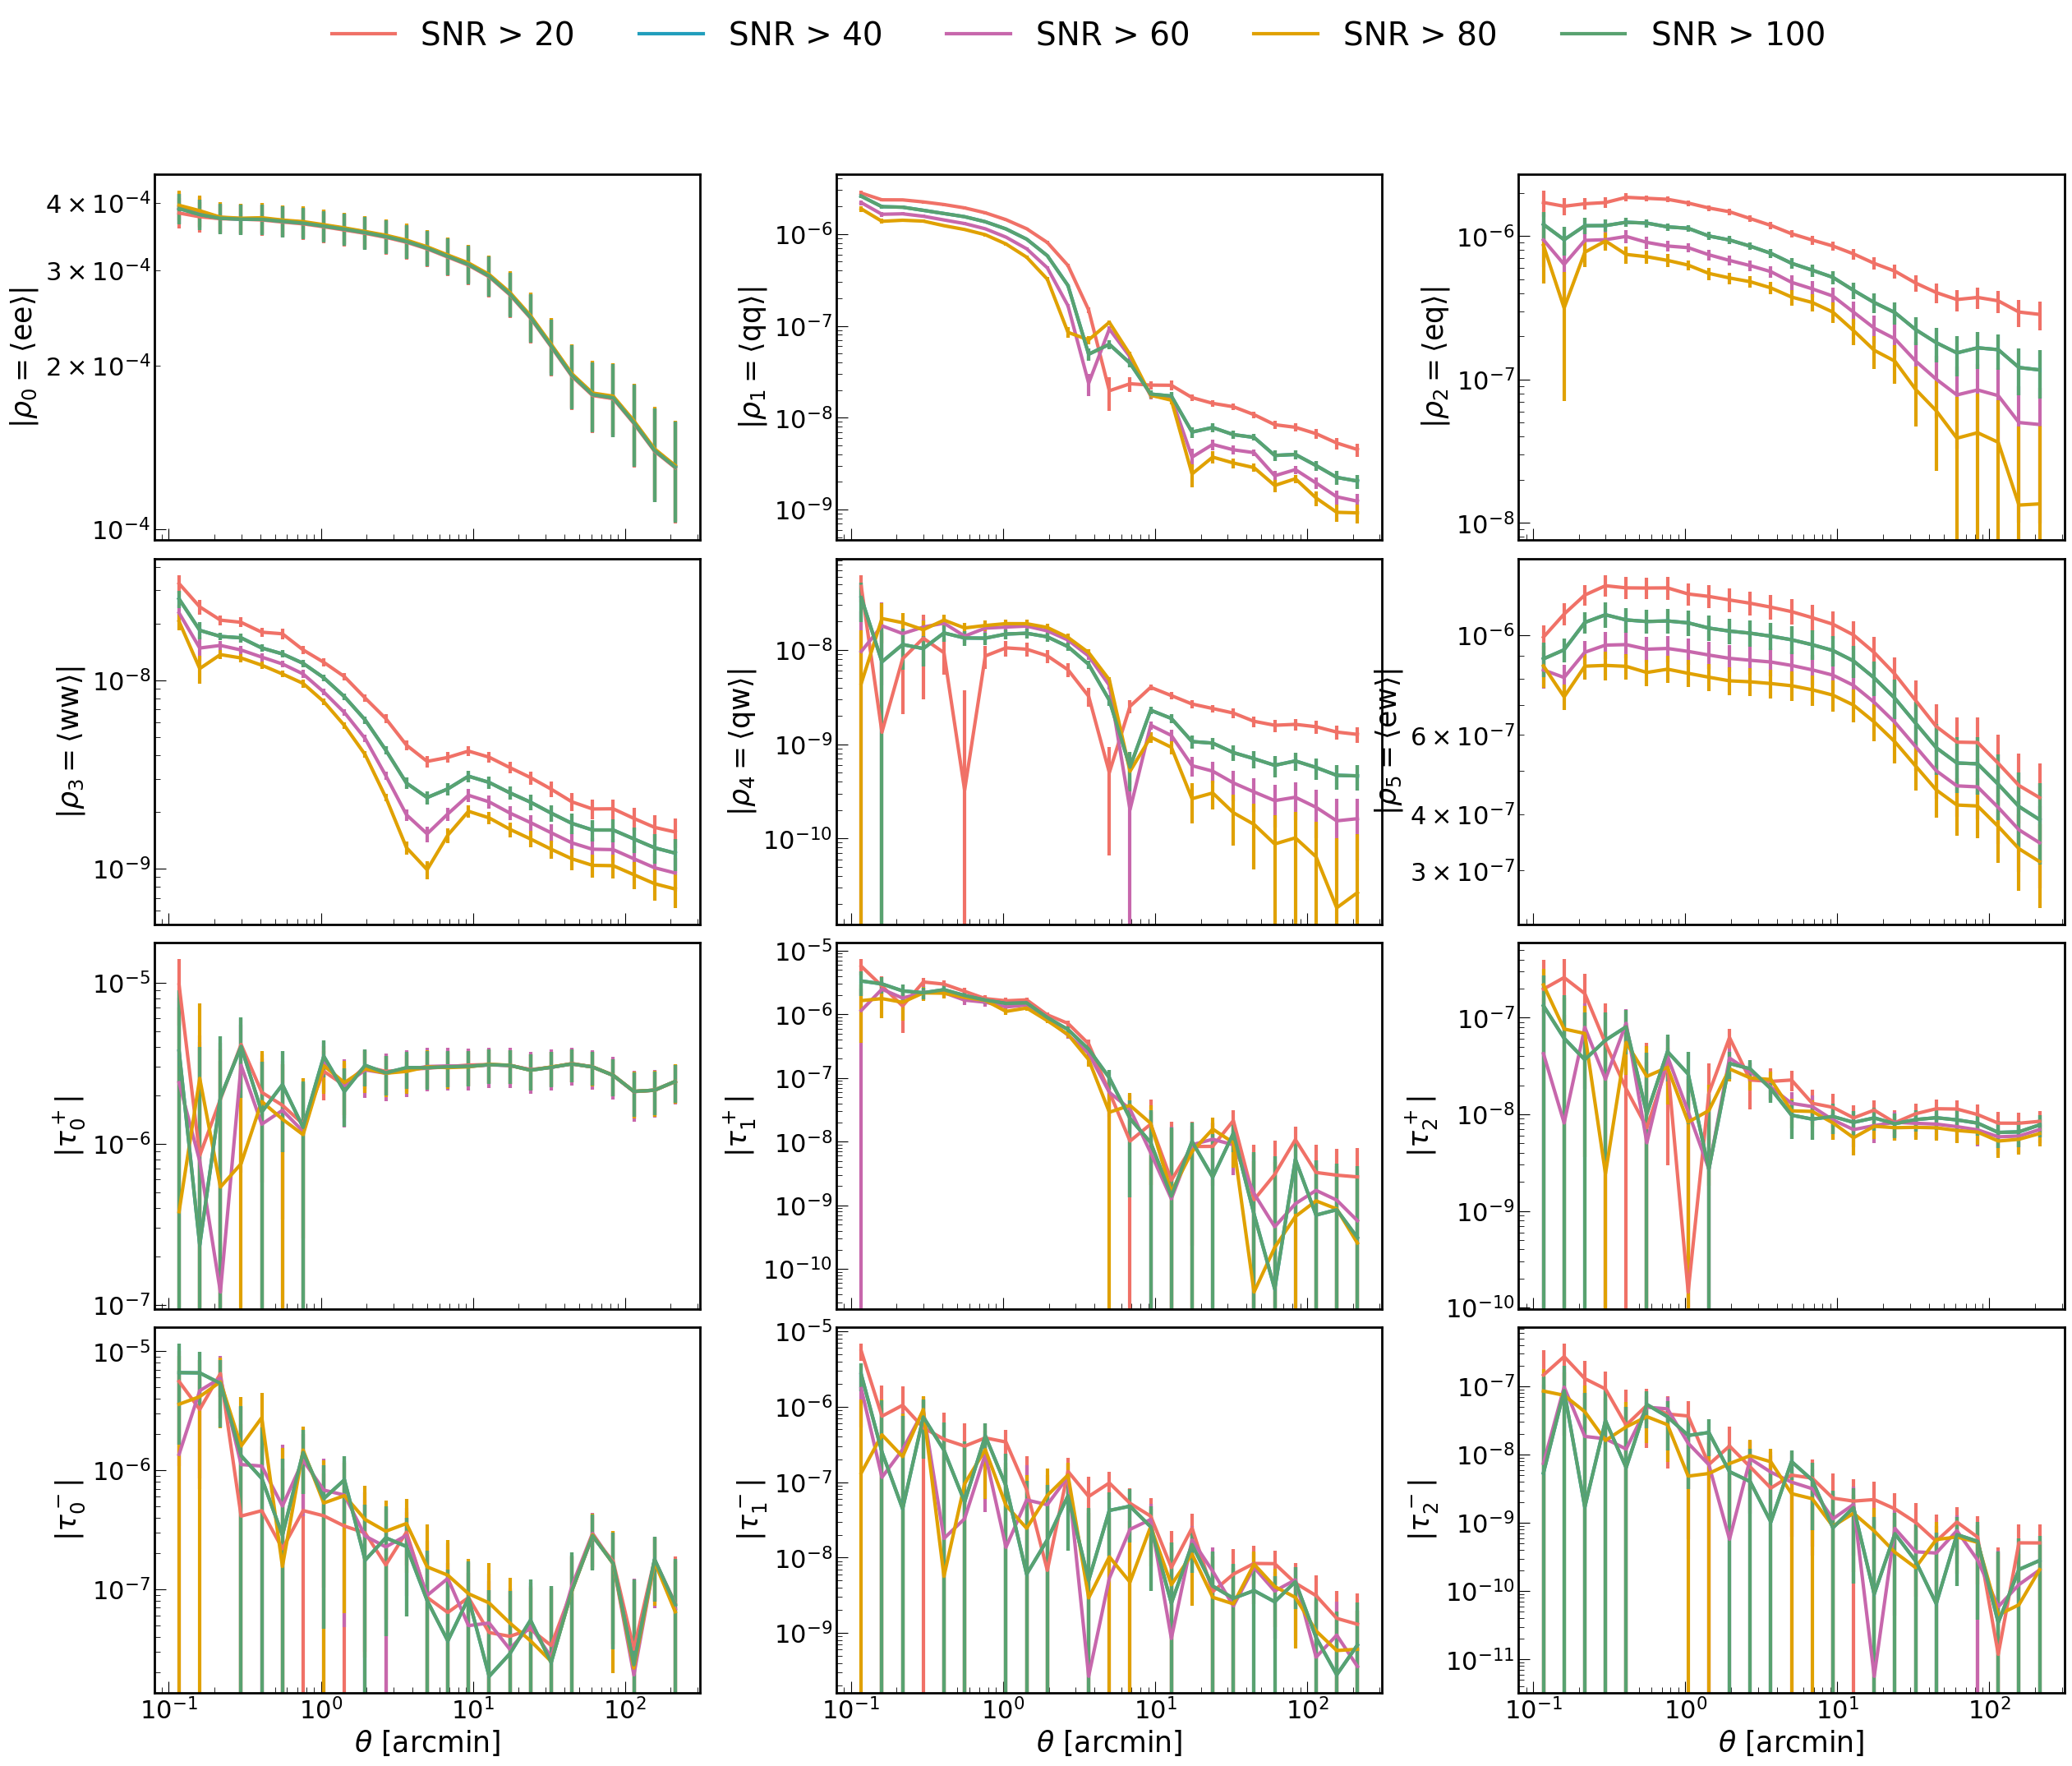

In [29]:
plt.rc("font", size=22)

fig, ax = plt.subplots(4, 3, figsize = (30, 24), sharex = True)

plt.subplots_adjust(hspace = 0.05, wspace = 0.25)

[a.loglog() for a in ax.flatten()]

paths = ['/scratch/midway3/dhayaa/SHEARTESTS/DR3_Masked_SNR20/',
         '/scratch/midway3/dhayaa/SHEARTESTS/DR3_Masked_SNR40/',
         '/scratch/midway3/dhayaa/SHEARTESTS/DR3_Masked_SNR60/',
         '/scratch/midway3/dhayaa/SHEARTESTS/DR3_Masked_SNR80/',
         '/scratch/midway3/dhayaa/SHEARTESTS/DR3_Masked_SNR100/',]

for p in paths:
    
    
    for i in range(6):

        x = np.loadtxt(p + '/taustats_rho%d_treecorr.txt' % i)
        ax.flatten()[i].errorbar(x[:, 0], np.abs(x[:, 3]), yerr = x[:, 7], lw = 3)

    for i in range(3):
    
        x = np.loadtxt(p + 'taustats_tau%d_treecorr.txt' % i)
        ax.flatten()[6 + i].errorbar(x[:, 0], np.abs(x[:, 3]), yerr = x[:, 7], lw = 3)
        ax.flatten()[6 + i + 3].errorbar(x[:, 0], np.abs(x[:, 4]), yerr = x[:, 8], lw = 3)

    
fig.legend([plt.plot([], [], lw = 3, )[0] for i in range(len(paths))], ['SNR > 20', 'SNR > 40',  'SNR > 60', 'SNR > 80',  'SNR > 100'],
           loc = 'center', ncol = 5, bbox_to_anchor = (0.5, 0.95), fontsize = 28, frameon = False)

for i, l in enumerate([r'$\rho_0 = \langle {\rm ee} \rangle$',
                       r'$\rho_1 = \langle {\rm qq} \rangle$',
                       r'$\rho_2 = \langle {\rm eq} \rangle$',
                       r'$\rho_3 = \langle {\rm ww} \rangle$',
                       r'$\rho_4 = \langle {\rm qw} \rangle$',
                       r'$\rho_5 = \langle {\rm ew} \rangle$'] + 
                      [r'$\tau_0^+$',
                       r'$\tau_1^+$',
                       r'$\tau_2^+$',
                       r'$\tau_0^-$',
                       r'$\tau_1^-$',
                       r'$\tau_2^-$']):
    ax.flatten()[i].set_ylabel(r'|%s|' % l, size = 25)
    
[ax.flatten()[i].set_xlabel(r'$\theta$ [arcmin]', size = 25) for i in [9, 10,  11]];

# ax.flatten()[0].set_ylim(7e-5, 1e-3)
# ax.flatten()[1].set_ylim(2e-9, 4e-6)
# ax.flatten()[2].set_ylim(1e-7, 2.5e-6)

# ax.flatten()[4].set_ylim(5e-10, 3.5e-8)
# ax.flatten()[5].set_ylim(9e-8, 2e-6)

# Check covariances

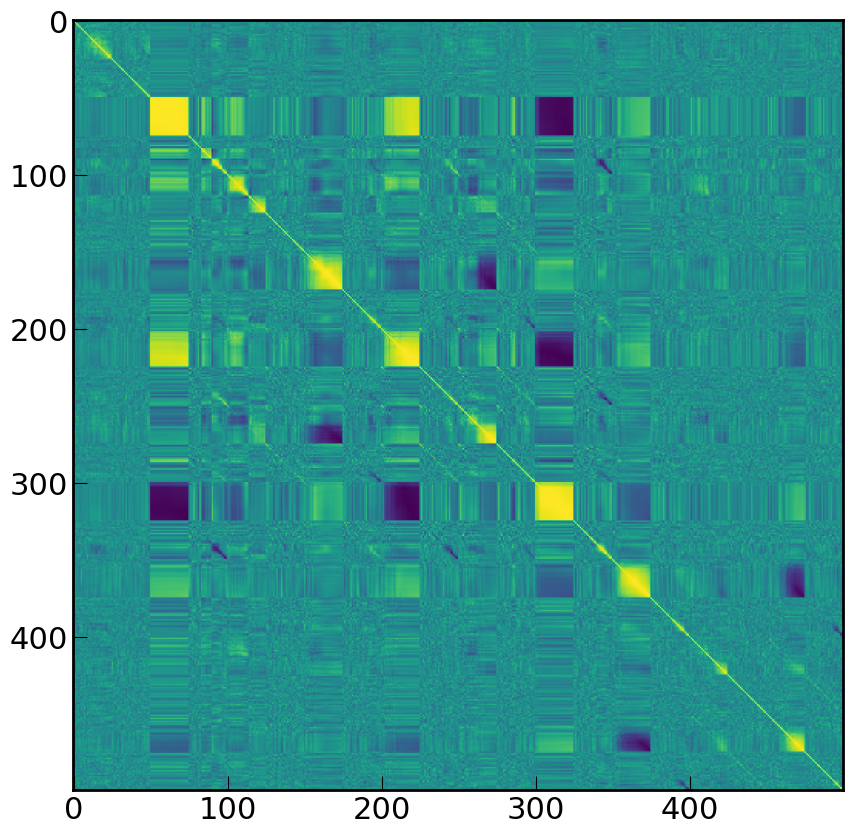

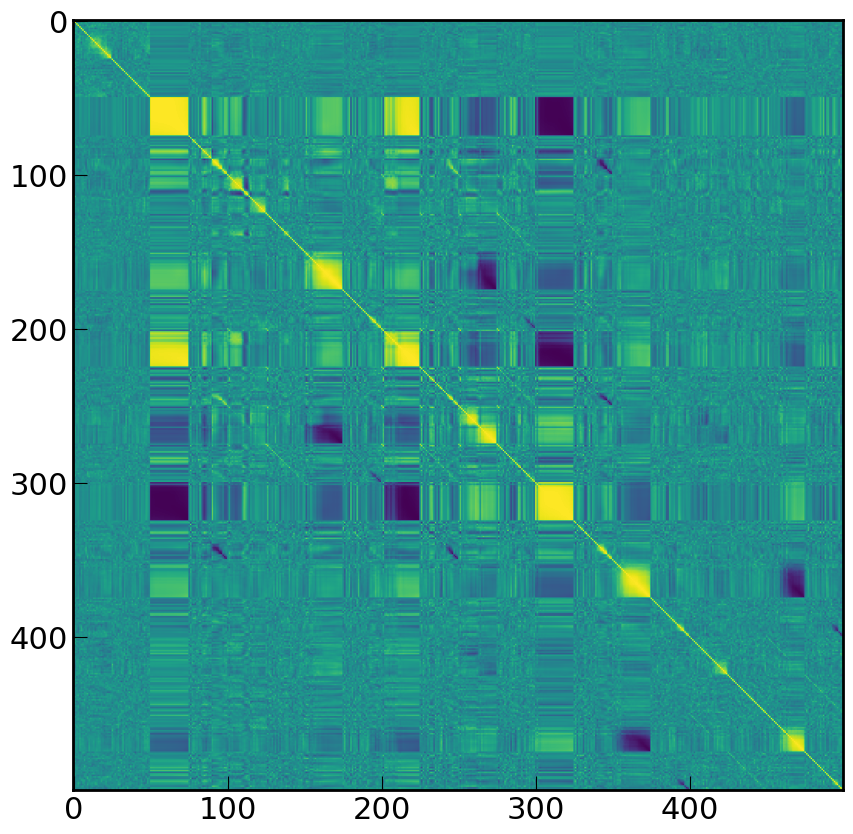

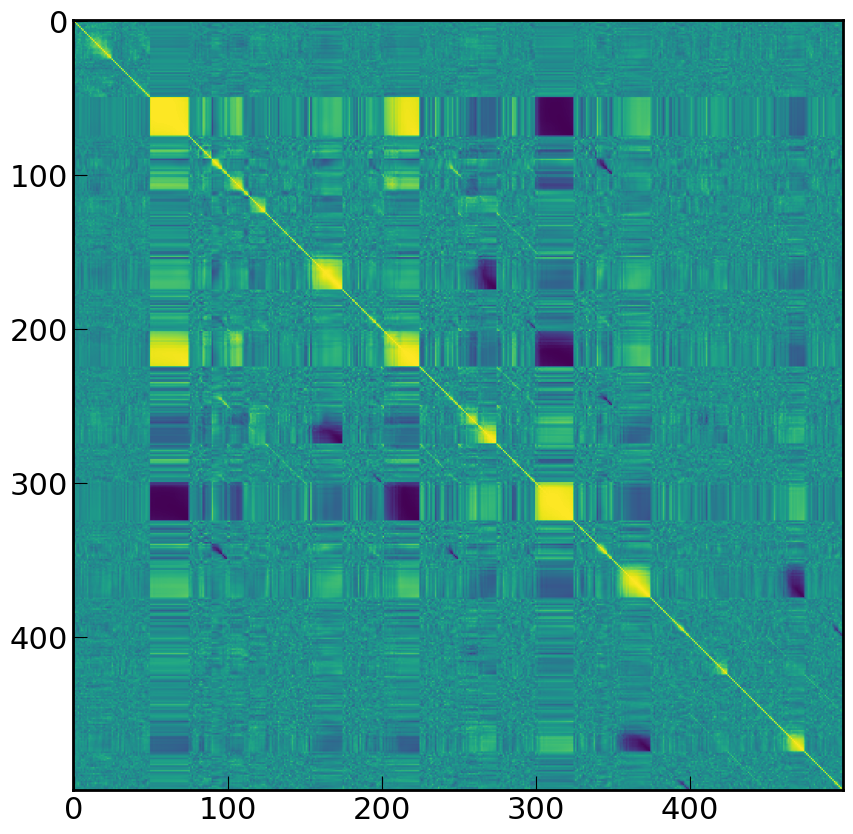

In [68]:

paths = ['/scratch/midway3/dhayaa/SHEARTESTS/DR3_Masked_SNR20/',
         '/scratch/midway3/dhayaa/SHEARTESTS/DR3_Masked/',
         '/scratch/midway3/dhayaa/SHEARTESTS/Ext0.2_Star5/']

for p in paths:
    
        
    cov  = np.loadtxt(p + '/taustats_All_cov_treecorr.txt')
    corr = cov/np.sqrt(np.outer(np.diagonal(cov), np.diagonal(cov)))
    
    plt.imshow(corr)
    plt.show()

# Check star catalog

In [44]:
import h5py

with h5py.File('/project/chihway/dhayaa/DECADE/star_psf_shapecat_20231216.hdf5', 'r') as f:
    
    SNR = f['FLUX_APER_8'][:] / f['FLUXERR_APER_8'][:]
    SNR_A = f['FLUX_AUTO'][:] / f['FLUXERR_AUTO'][:]
    print(list(f.keys()))

/home/dhayaa/ipykernel_4049429/375928099.py:5: RuntimeWarning: invalid value encountered in true_divide
  SNR = f['FLUX_APER_8'][:] / f['FLUXERR_APER_8'][:]


['A_planck13', 'A_sfd98', 'BAND', 'CCDNUM', 'EXPNUM', 'FLUXERR_APER_8', 'FLUXERR_APER_8_DERED_PLANCK13', 'FLUXERR_APER_8_DERED_SFD98', 'FLUXERR_AUTO', 'FLUXERR_AUTO_DERED_PLANCK13', 'FLUXERR_AUTO_DERED_SFD98', 'FLUX_APER_8', 'FLUX_APER_8_DERED_PLANCK13', 'FLUX_APER_8_DERED_SFD98', 'FLUX_AUTO', 'FLUX_AUTO_DERED_PLANCK13', 'FLUX_AUTO_DERED_SFD98', 'IMAFLAGS_ISO', 'MAGZP', 'MAG_AUTO', 'T_model_hsm', 'T_star_hsm', 'dec', 'focal_x', 'focal_y', 'g1_model_hsm', 'g1_star_hsm', 'g2_model_hsm', 'g2_star_hsm', 'pix_x', 'pix_y', 'ra']


/home/dhayaa/ipykernel_4049429/375928099.py:6: RuntimeWarning: invalid value encountered in true_divide
  SNR_A = f['FLUX_AUTO'][:] / f['FLUXERR_AUTO'][:]


In [49]:
inds = np.load('/scratch/midway3/dhayaa/SHEARTESTS/DR3_Masked/psf_inds.npy')

In [46]:
SNR.size

1636091734

/home/dhayaa/ipykernel_4049429/2737728328.py:2: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(1 + SNR_A[inds]), bins = 1000, log = True, alpha = 0.6);


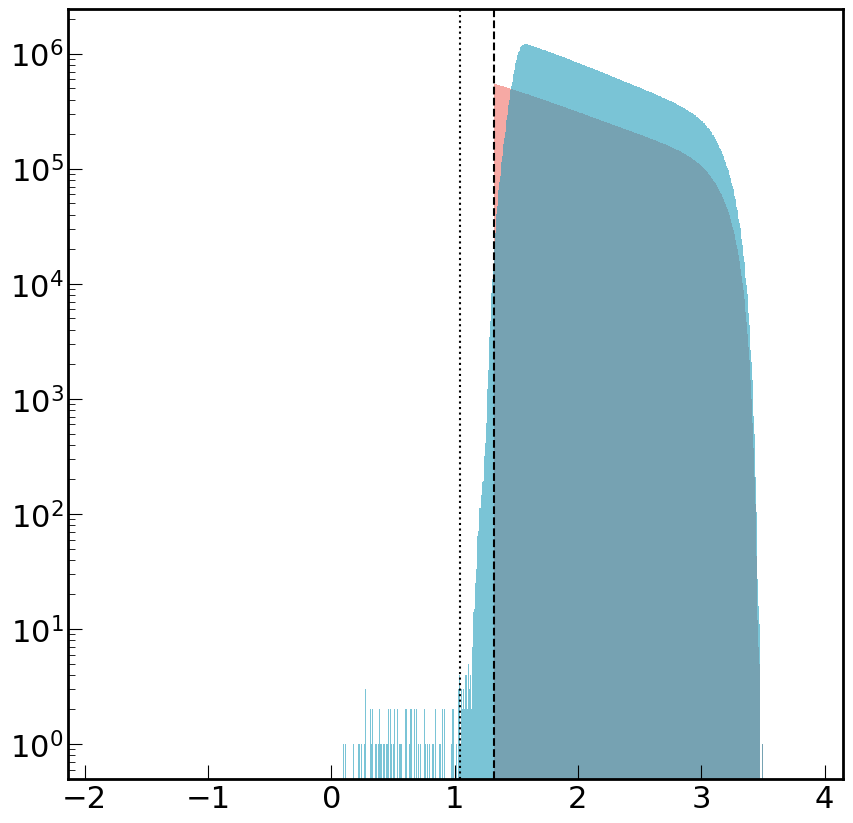

In [50]:
plt.hist(np.log10(1 + SNR[inds]), bins = 1000, log = True, alpha = 0.6);
plt.hist(np.log10(1 + SNR_A[inds]), bins = 1000, log = True, alpha = 0.6);
plt.axvline(np.log10(1 + 20), color = 'k', ls = '--')
plt.axvline(np.log10(1 + 10), color = 'k', ls = ':')

/home/dhayaa/ipykernel_4049429/2737728328.py:2: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(1 + SNR_A[inds]), bins = 1000, log = True, alpha = 0.6);


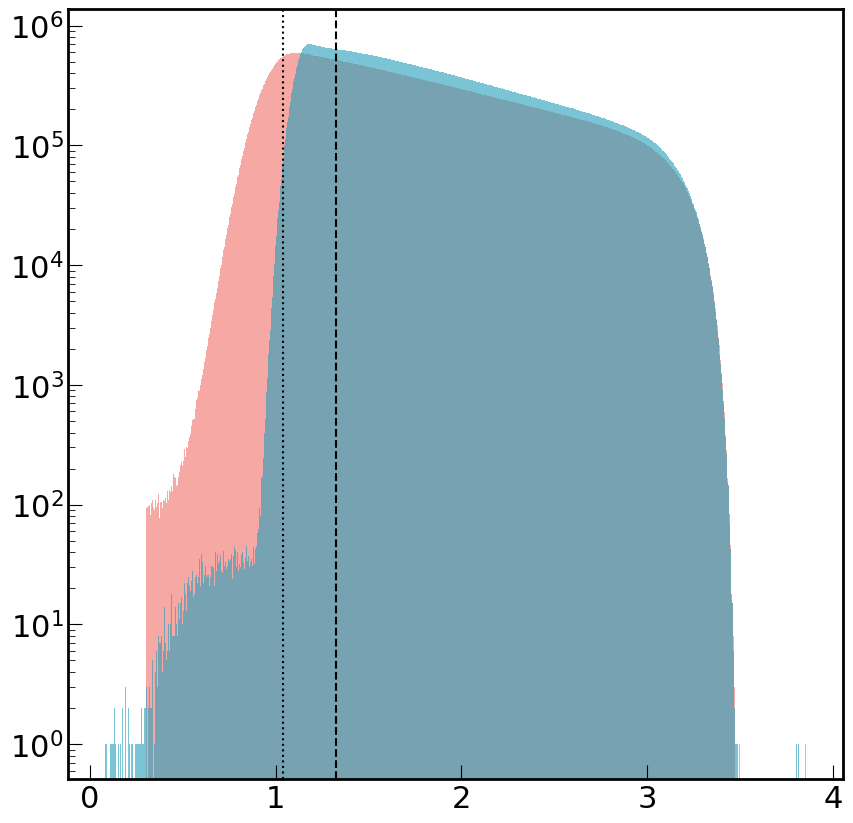

In [45]:
plt.hist(np.log10(1 + SNR[inds]), bins = 1000, log = True, alpha = 0.6);
plt.hist(np.log10(1 + SNR_A[inds]), bins = 1000, log = True, alpha = 0.6);
plt.axvline(np.log10(1 + 20), color = 'k', ls = '--')
plt.axvline(np.log10(1 + 10), color = 'k', ls = ':')

In [48]:
np.average(SNR > 20)

0.688778466134589

/home/dhayaa/ipykernel_4049429/1205464037.py:1: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(1 + SNR), bins = 1000, log = True, alpha = 0.6);
/home/dhayaa/ipykernel_4049429/1205464037.py:2: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(1 + SNR_A), bins = 1000, log = True, alpha = 0.6);


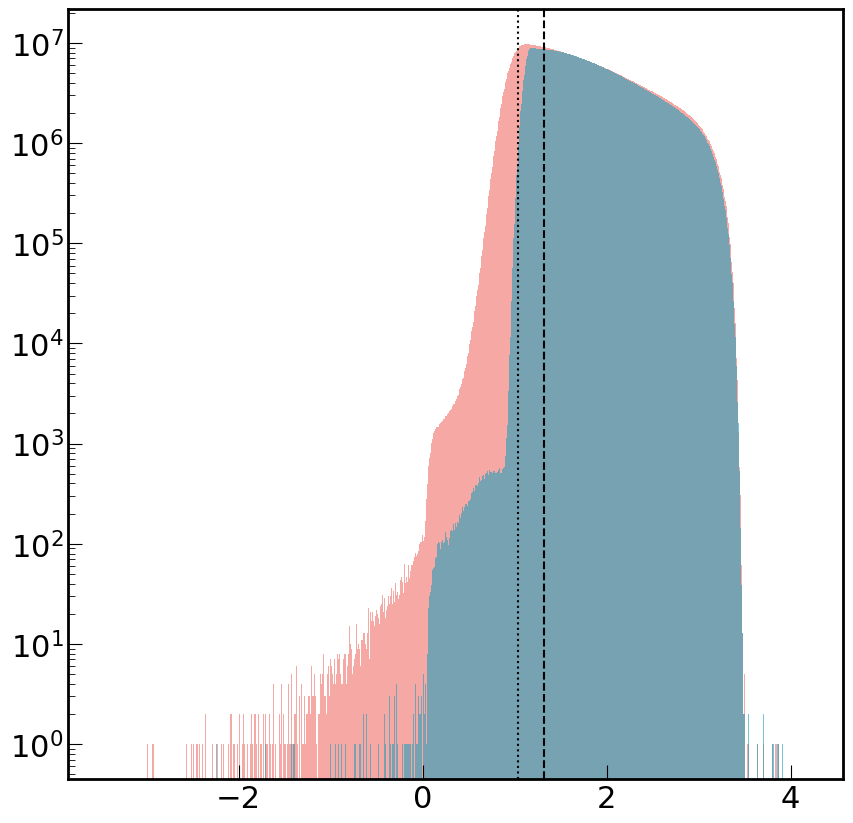

In [47]:
plt.hist(np.log10(1 + SNR), bins = 1000, log = True, alpha = 0.6);
plt.hist(np.log10(1 + SNR_A), bins = 1000, log = True, alpha = 0.6);
plt.axvline(np.log10(1 + 20), color = 'k', ls = '--')
plt.axvline(np.log10(1 + 10), color = 'k', ls = ':')

In [ ]:
import h5py

with h5py.File('/project/chihway/dhayaa/DECADE/star_psf_shapecat_20231216.hdf5', 'r') as f:
    
    SNR = f['FLUX_APER_8'][:] / f['FLUXERR_APER_8'][:]
    print(list(f.keys()))